In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 0. 데이터 준비하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.head(10)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...


In [4]:
data.loc[[34,54,280]]

,headlines,text
34,CM Parrikar under pressure from PM after our G...,Rahul Gandhi has replied to Goa CM Manohar Par...
54,"Can never look at female body, even if naked, ...","Filmmaker Pooja Bhatt, while talking about the..."
280,"Global 'waming', we need you: Trump",As several parts of the US experience extreme ...


# 1. 데이터 전처리


### 1.1 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [6]:
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


headlines에서 121개 중복 <br>
text에서 41개 중복

비슷한 기사라서 헤드라인이 유사한것일수도 있으니 일단 text 중복 샘플만 제거해보자
``drop_duplicate()`` 로 중복 샘플 제거

In [7]:
# inplace=True : data 내부를 직접적으로 바꾼다.
# 먼저 Text 컬럼에서 중복 제거 해보자
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
# 데이터프레임에 Null값 있는 지 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 1.2 텍스트 정규화와 불용어 제거
-  it'll은 it will과 같고, mustn't과 must not은 사실 같은 표현
- 학습 전에 미리 같은 표현으로 통일시켜줘야 기계 연산량 줄일 수 있다

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


자연어 처리에 불필요한 단어들이 텍스트 데이터 존재 <br>
불필요한 단어 = 불용어 <br>
#### **불용어 제거**해서 자연어 처리 성능 높이기
- NLTK 라이브러리에서 제공하는 불용어 리스트 참조해서 불용어 제거해보자

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의해서 제공하는 불용어는 **총 179개**

> #### 불용어 외에도 데이터 전처리 필요
> 1. 텍스트 소문자화
> 2. 섞여있는 html 태그 제거
> 3. 괄호로 닫힌 문자열 제거
> 4. 이전에 만든 contractions 사전 이용해서 텍스트 정규화
> 5. 소유격 제거
> 6. 영어 외 숫자,특수문자는 공백으로 변환
> 7. m이 3개 이상이면 2개로 변경

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

headlines에 대해 전처리 함수 호출할때는<br>
불용어 제거 X -> ``preprocess_sentence(s,False)``<br>
두 번째 인자 **False**로 넣어준다!

In [12]:
# 결과 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


결과 확인 후 **전체 Text 데이터**에 대한 전처리 해보자

In [13]:
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [14]:
print("Text 전처리 후 결과: ", clean_text[5:10])

Text 전처리 후 결과:  ['pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first publicised reads press release issued behalf rahat statement called allegation bizarre', 'india recorded lowest odi total new zealand getting runs overs fourth odi hamilton thursday seven india batsmen dismissed single digit scores number ten batsman yuzvendra chahal top scored india previous lowest odi total new zealand', 'weeks ex cbi director alok verma told department personnel training consider retired home ministry asked join work last day fixed tenure director thursday ministry directed immediately join dg fire services post transferred removal cbi chief', 'andhra pradesh cm chandrababu naidu said met us president bill clinton addressed mr clinton sir modi junior politics addressed sir times satisfy ego hope justice state added', 'congress candidate shafia zubair ramgarh assembly seat

In [15]:
clean_summary = []

for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s))

# 전처리 후 출력
print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches career ml al salary hike', 'delhi techie wins free food swiggy one year cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'known hirani yrs metoo claims true sonam']


텍스트 정제 후 데이터 쉽게 확인하기 위해 데이터프레임에 재저장.<br>
빈값은 Null 값으로 대체하자

In [16]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.head()

,headlines,text
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98360 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98360 non-null  object
 1   text       98360 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [18]:
# Null값 있는 지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 1.3 Train/Test 데이터 나누기

#### 1.3.1 샘플 최대 길이 정하기

Text의 최소 길이 : 1
Text의 최대 길이 : 60
Text의 평균 길이 : 35.09968483123221
Summary의 최소 길이 : 1
Summary의 최대 길이 : 13
Summary의 평균 길이 : 7.136183407889386


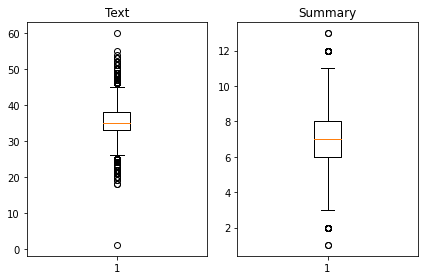

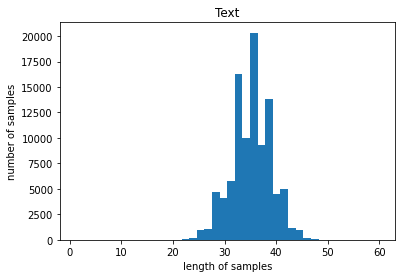

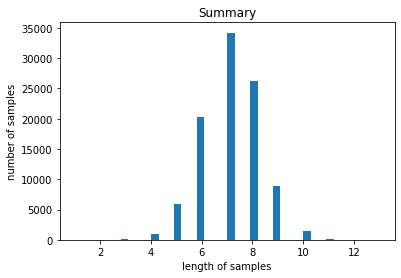

In [19]:
# Text와 Summary의 최소, 최대, 평균 길이를 구해서
# 길이 분포 시각화
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('Text의 최소 길이 : {}'.format(np.min(text_len)))
print('Text의 최대 길이 : {}'.format(np.max(text_len)))
print('Text의 평균 길이 : {}'.format(np.mean(text_len)))
print('Summary의 최소 길이 : {}'.format(np.min(summary_len)))
print('Summary의 최대 길이 : {}'.format(np.max(summary_len)))
print('Summary의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

분포가 그래도 고르다.

Text 최대길이와 Summary 따로 설정할 필요 없어 보인다.

#### 1.3.2 시작 토근과 종료 토큰 추가하기

[Seq2seq Framework Basics]
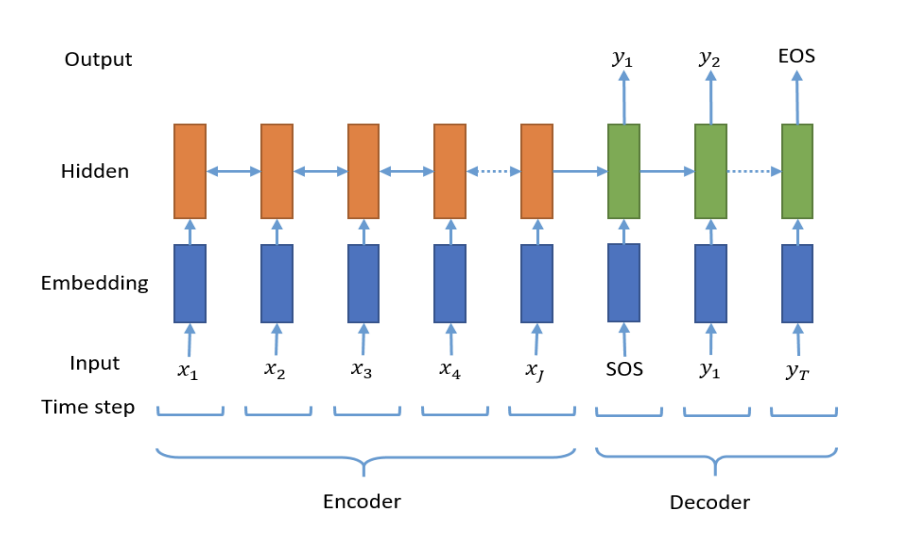
출처 - [Neural Abstractive Text Summarization with
Sequence-to-Sequence Models]("https://arxiv.org/pdf/1812.02303.pdf")

Encoder - source 데이터를 가져와 hidden state 생성<br>
Decoder - hidden state를 context input으로 사용해서 summary 출력

**Decoder에서는 시작 토큰과 종료 토큰을 넣어주는 전처리가 필요하다.**

시작 토큰 : ``sostoken``  

종료 토큰 : ``eostoken``

In [20]:
# Summary 데이터에 시작 토큰과 종료 토큰을 추가
data['decoder_input']=data['headlines'].apply(lambda x: 'sostoken ' + x)
data['decoder_target']=data['headlines'].apply(lambda x: x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken


In [21]:
# 인코더의 입력 : text 데이터
# 디코더의 입력/레이블 Numpy 타입으로 저장하기
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

#### 1.3.3 드디어 훈련데이터, 테스트데이터 분리!!

In [22]:
np.arange(encoder_input.shape[0])

array([    0,     1,     2, ..., 98357, 98358, 98359])

In [23]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices) # 인덱스 섞어~
print(indices)

[32924 18959 51727 ... 48680 26579 19286]


In [24]:
print(len(indices))

98360


In [25]:
# 위에 정의한 indices 사용해서 샘플 순서 섞어주자
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [26]:
# 8:2 비율로 분리
n_of_val = int(len(encoder_input)*0.2)
print("Validation data의 개수:",n_of_val)

Validation data의 개수: 19672


In [27]:
# train, test data 나눠담기
# [:-n_of_val] : n_of_val 제외하고 출력
# [-n_of_val:] : n_of_val 부분(제일 뒷부분) 출력
encoder_input_train = encoder_input[:-n_of_val]  
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


### 1.4 정수 인코딩

#### 1.4.1 단어집합(vocabulary) 만들기 및 정수 인코딩
컴퓨터가 텍스트를 숫자로 처리할 수 있도록 단어들을 모두 정수로 바꿔준다

#### tokenizer 메서드 정리
- ``tokenizer = Tokenizer(num_words = 100)`` : num_words를 **단어 빈도수가 높은 순으로 100개만 사용한다**는 의미이다. 나머지는 고려하지 않는다.
- ``tokenizer.fit_on_texts(sentences)`` : 문자 데이터를 입력받아서 리스트의 형태로 변환 

- ``tokenizer.word_index`` : 단어와 숫자의 키-값 쌍을 포함하는 딕셔너리를 반환. 이때, 반환 시 자동으로 소문자로 변환되어 들어간다. 그리고 느낌표나 마침표 같은 구두점은 자동으로 제거

- ``tokenizer.word_counts.items()``에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보 얻기 가능

- ``tokenizer.texts_to_sequences()`` : 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행

In [28]:
# 'text' 데이터 담겨있는 encoder_input_train에 대한 단어집합 만들기
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력 데이터로 단어집합 생성

#### 단어 등장 빈도수 확인

In [29]:
# 등장 빈도수 6회 미만 단어들 보자
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 전체 단어의 수
rare_cnt = 0 # 등장 빈도수 threshold보다 작은 단어 개수 
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈도수 threshold보다 작은 단어 등장 빈도수의 총합

# 단어와 빈도수 key,value로 받는다.
for key,value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value<threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)       

단어 집합(vocabulary)의 크기 : 69741
등장 빈도가 5번 이하인 희귀 단어의 수: 45713
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24028
단어 집합에서 희귀 단어의 비율: 65.54680890724252
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.0925113864596447


등장 빈도 6회 미만(5회 이하)인 단어가 단어집합 약 65% 차지한다 <br>
전체 등장빈도와 비교하면 회귀 단어 등장 반도는 3%로 매우 작기 때문에 훈련데이터에서 제거하고 시작한다

In [30]:
# 단어 집합에서 회귀 단어 제외시킬 경우 단언 집합 크기 24000개 정도 였음
# 단어 집합 크기 10000으로 제한시켜보자
src_vocab =10000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 빈도수가 높은 순으로 num_words만큼 사용
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [31]:
changed_total_cnt = len(src_tokenizer.word_index)
print(changed_total_cnt)

69741


### 여기서 궁금한 점 1
> **단어 집합을 그냥 24000으로 제한한다고 빈도수가 작은 단어가 포함이 안된다고 볼수있나??**
> -  토크나이저 정의할 때 ``num_words`` 인수로 단어 집합의 크기를 제한 가능
> - Tokenizer자체에서 빈도수 기준으로 24000까지 줄세워줌

### 궁금한 점 2 
> **왜 24000개로 제한이 안됐지???**
> - ``len(src_tokenizer.word_index)``은 토큰화한 전체 단어수이기때문에 재생성한 단어 집합 수와 다르다. 아닌거 같은데,,,? 도대체 뭘까??

In [32]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2225, 1801, 3500, 23, 3653, 1015, 2081, 1946, 679, 803, 96, 16, 2537, 4181, 1601, 1801, 3653, 2081, 1946, 1110, 401, 329, 1992, 7158, 4181, 2250, 205, 4181, 1115, 205, 401, 44, 32, 1960], [120, 20, 598, 62, 974, 729, 7073, 74, 211, 917, 3654, 11, 2285, 392, 20, 2459, 331, 211, 6267, 496, 3654, 1472, 508, 11, 2285, 2361, 7073, 496, 211, 76, 3654], [31, 673, 943, 1140, 73, 40, 3, 311, 3, 369, 196, 214, 100, 486, 2, 276, 250, 532, 3937, 2495, 894, 3863, 2569, 943, 1082, 91, 26, 40, 6, 780, 31, 136, 31, 8848, 12, 944, 1482]]


In [33]:
# 인코딩 후 24000 넘는 숫자 있는지 확인 -> 없음
for i in encoder_input_train:
    for j in i:
        cnt = 0
        if j >10000:
            cnt = cnt + 1
print(cnt)

0


#### Summary 데이터에서도 위와 동일한 작업 해주기

In [34]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [35]:
threshold = 4
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29974
등장 빈도가 3번 이하인 희귀 단어의 수: 16951
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 13023
단어 집합에서 희귀 단어의 비율: 56.55234536598386
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.993975602439756


In [36]:
tar_vocab = 7000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2002, 3068, 810, 939, 67, 896], [1, 6058, 2358, 49, 479, 5308, 113, 80], [1, 329, 657, 53, 61, 21, 59, 233, 220], [1, 384, 1272, 52, 2630], [1, 28, 6, 47, 67, 1352, 2685, 2095, 1641]]
target
decoder  [[2002, 3068, 810, 939, 67, 896, 2], [6058, 2358, 49, 479, 5308, 113, 80, 2], [329, 657, 53, 61, 21, 59, 233, 220, 2], [384, 1272, 52, 2630, 2], [28, 6, 47, 67, 1352, 2685, 2095, 1641, 2]]


그런데 Summary의 길이 0인 샘플이 있을수도 있다.

``decoder_input``에는 <sos> 토큰, ``decoder_target``에는 <eos> 추가된 상태이기 때문에 길이가 0이라고 나오지는 않을 것이다.
    
Summary 길이가 1인 경우를 뽑아보고 이런 경우 기존 샘플에서 삭제하자!

In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 2
삭제할 테스트 데이터의 개수 : 3
훈련 데이터의 개수 : 78686
훈련 레이블의 개수 : 78686
테스트 데이터의 개수 : 19669
테스트 레이블의 개수 : 19669


#### 1.4.2 패딩하기
텍스트 시퀀스를 정수 시퀀스로 변환하고 나서는 서로 다른 길이의 샘플들은 같은 길이로 맞춰줘야한다. <br>
pre-padding이 post-padding 보다 성능 좋다는 결과가 있다.<br>
``pad_sequences()``로 앞에 0을 넣어 최대 길이로 길이를 맞춰주자

In [38]:
text_max_len = 60
summary_max_len = 13

In [39]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# 2. 모델 설계

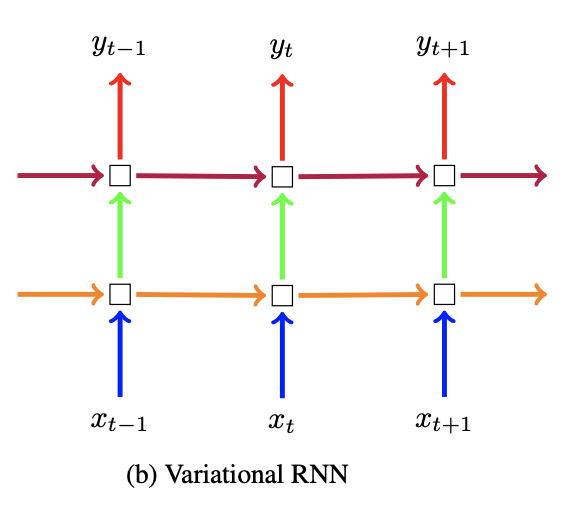
- Variational Droput - dropout 과 recurrent dropout 모두 사용한 것
- ``dropout`` :  레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법
- ``recurrent dropout`` : 레이어가 아닌 time step마다 드롭아웃 해주는 방식


-> 둘 다 regularization + 과적합 방지해주는 효과 있음

### 2.1 LSTM 모델 이용

[LSTM Framework]
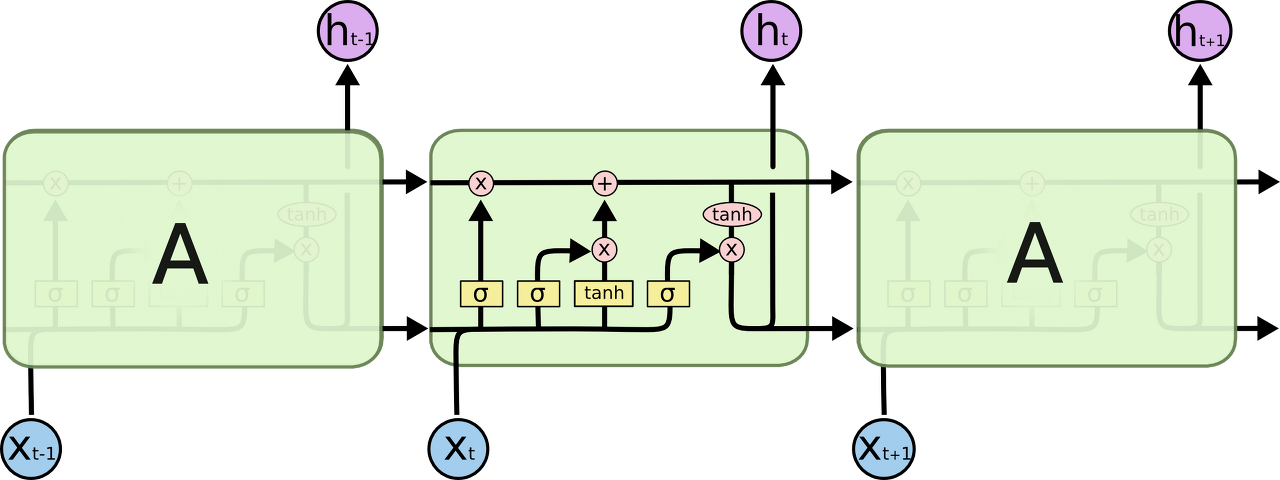

#### 2.1.1 인코더 설계

In [40]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1 
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


-> **recurrent dropout을 사용할 시 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래 걸린다.**
### 궁금한 점 3
> recurrent dropout 사용 시 학습 시간 너무나도 오래 걸리는데 굳이 사용해야하는 이유는 무엇인가? <br>
> 학습 속도가 엄청 느려도 성능을 효과적으로 많이 높여주긴 하나? <br>
> recurrent dropout 없이 한번 돌려보자

#### 2.1.2 디코더 설계
- 인코더 설계와 비슷하지만 ``initial_state`` 인자값으로 hidden_state 와 cell sate 값 넣어주는 거만 다르다.

In [41]:
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,_,_ = decoder_lstm(dec_emb, initial_state=[state_h,state_c])

In [42]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1280000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 2.2 Attention 이용
어텐션 메커니즘을 이용해 디코더의 출력층을 새롭게 설계

In [43]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1280000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

# 3. 모델 훈련
[EarlyStopping 옵션 관련 참고 자료](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)
- ``EarlyStopping(monitor='val_loss', patience=2, verbose=1)`` : 특정 조건이 충족되면 훈련을 멈추는 역할을 한다. 검증 데이터 손실이 줄어들지 않고 증가하는 현상이 2회 관측되면 학습이 멈추도록 설정돼있음


In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1,mode='min')
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 254s 797ms/step - loss: 4.0635 - val_loss: 3.7300
Epoch 2/50
308/308 [==============================] - 250s 811ms/step - loss: 3.6302 - val_loss: 3.4381
Epoch 3/50
308/308 [==============================] - 249s 807ms/step - loss: 3.3752 - val_loss: 3.2656
Epoch 4/50
308/308 [==============================] - 245s 796ms/step - loss: 3.2004 - val_loss: 3.1362
Epoch 5/50
308/308 [==============================] - 247s 802ms/step - loss: 3.0524 - val_loss: 3.0344
Epoch 6/50
308/308 [==============================] - 247s 803ms/step - loss: 2.9267 - val_loss: 2.9464
Epoch 7/50
308/308 [==============================] - 247s 801ms/step - loss: 2.8197 - val_loss: 2.8809
Epoch 8/50
308/308 [==============================] - 249s 808ms/step - loss: 2.7267 - val_loss: 2.8270
Epoch 9/50
308/308 [==============================] - 245s 795ms/step - loss: 2.6443 - val_loss: 2.7825
Epoch 10/50
308/308 [==============================] - 246s 799m

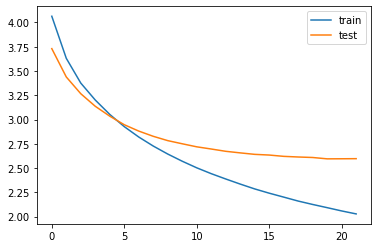

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 4. 인퍼런스 모델 구현하기
테스트 단계에선 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원한다

In [40]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [47]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])



### 어텐션 메커니즘 사용하는 출력층 설계

In [48]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### 단어 스퀀스 완성하는 함수 만들기

In [49]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS> 에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 5. 모델 테스트하기

In [50]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp


테스트 데이터 약 500개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보자

In [51]:
dic = {}
for i in range(50, 100):
    #try:
        print("원문 :", seq2text(encoder_input_test[i]))
        print("실제 요약 :", seq2summary(decoder_input_test[i]))
        print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))    
        print("\n")
    #except KeyError:
        #dic[i]=1
#print(dic)


원문 : deputy superintendent police kerala arrest accused causing year old death found hanging home tuesday allegedly pushed man front speeding vehicle altercation parked cars november run since 
실제 요약 : kerala pushed man death found hanging home 
예측 요약 :  kerala police arrest hanging man


원문 : year old woman arrested delhi airport allegedly attempting smuggle gold worth lakh according official statement issued tuesday woman intercepted arrival bangkok also admitted smuggling gold valued lakh past 
실제 요약 : woman caught smuggling gold rectum delhi airport 
예측 요약 :  delhi woman held smuggling gold worth delhi


원문 : kevin holds record scoring fastest ever world cup hundred recorded ireland first ever test hundred first ever match pakistan monday year old achieved feat balls becoming third oldest register ton test debut fourth batsman score century team test debut 
실제 요약 : wc history fastest ton scorer hits ireland st test ton 
예측 요약 :  records highest ever score tests


원문 : recently appo

## 앞에선 seq2seq 통해서 추상적 요약을 진행


# 6. 추출적 요약 해보기

### summarize 사용하기
``summarize()`` 의 인자
- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
- 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [2]:
!pip install summa

     |████████████████████████████████| 54 kB 2.9 MB/s eta 0:00:011
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54411 sha256=e5899c88a323f97963b8e52f4e57ba4d66a8c1b75ec443cf3d7bef2a2f64ad0a
  Stored in directory: /Users/minyeong/Library/Caches/pip/wheels/fd/6a/dd/209eb19d5f2266b9cfd06827539bf70435b0ad5fe8244e52d3
Successfully built summa


In [3]:
import requests
from summa.summarizer import summarize
import pandas as pd

import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data1 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [4]:
for idx, (head, text) in enumerate(zip(data1['headlines'], data1['text'])):
    if idx == 10:
        break
    print("원문 :", text)
    print("실제 요약 :", head)
    print("예측 요약 :", summarize(text, words=10))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : 


원문 : New Zealand defeated India by 8 wicke

# 회고
---
- 이번 프로젝트는 학습시간이 오래걸려서 너무 힘들었다,,
- 근데 노력과 달리 요약이 너무 이상하게 되서 실망스러웠다 ㅎ
- 일단 앞에 궁금한 점 3개 중 2개는 아직 이유를 못찾았기 때문에 더 알아볼 필요가 있다.
- 초반에 계속 요약문이 안나오고 sostoken에 KeyError 오류가 나서 보니 내가 토근을 넣어줄때 sostoken 뒤에 띄어쓰기와 eostoken 앞에 띄어쓰기를 깜빡했었다. 다음부터 조심하자^^
- 아직 LSTM과 Attention 모델 구조에 대한 파악이 부족해서 모델링 코드가 학습하고 결과값을 출력하는 과정에 대학 정확한 파악이 안되었다.
- LSTM, Attention 모델 구조에 대해 정리하고 다시 구현해볼 예정이다.
- LSTM, Attention은 이해하고 나서 Transformer 공부 후 적용해 성능을 높여볼 예정이다.
- [Fine-tune BERT for Extractive Summarization](https://arxiv.org/pdf/1903.10318.pdf) 논문 참고해서 요약 성능 높여보자